In [165]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


tf.__version__

'2.11.0'

In [166]:
# Load dataset
csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,644.6140,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [167]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

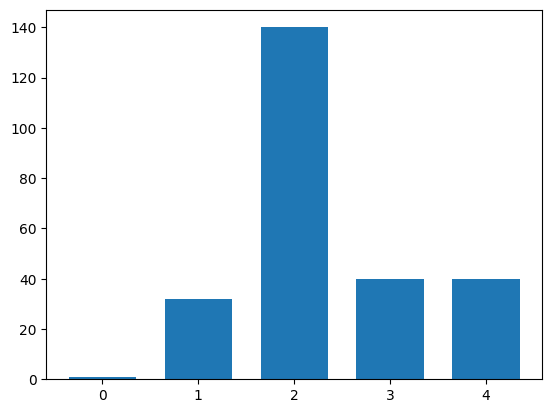

In [168]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [169]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.0000,0.0000,0.0000,1.0000,4.0000
Pos2,253.0,0.774704,1.388956,0.0000,0.0000,0.0000,1.0000,4.0000
Pos3,253.0,0.632411,1.258013,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,253.0,0.557312,1.218930,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,253.0,0.513834,1.121934,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,253.0,0.430830,1.054167,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,253.0,0.383399,1.007532,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,253.0,0.533597,1.163200,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,253.0,0.332016,0.904378,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,253.0,0.284585,0.867193,0.0000,0.0000,0.0000,0.0000,4.0000


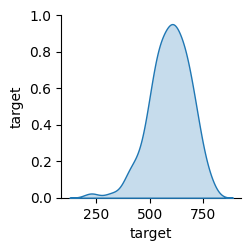

In [170]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set
sns.pairplot(dataframe[['target']], diag_kind='kde')


In [171]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min      25%       50%       75%  \
Pos1    249.0    0.646586   1.239308    0.0000    0.000    0.0000    1.0000   
Pos2    249.0    0.738956   1.353061    0.0000    0.000    0.0000    1.0000   
Pos3    249.0    0.614458   1.239452    0.0000    0.000    0.0000    0.0000   
Pos4    249.0    0.534137   1.187909    0.0000    0.000    0.0000    0.0000   
Pos5    249.0    0.510040   1.118439    0.0000    0.000    0.0000    0.0000   
Pos6    249.0    0.437751   1.061202    0.0000    0.000    0.0000    0.0000   
Pos7    249.0    0.389558   1.014438    0.0000    0.000    0.0000    0.0000   
Pos8    249.0    0.542169   1.170551    0.0000    0.000    0.0000    0.0000   
Pos9    249.0    0.337349   0.910651    0.0000    0.000    0.0000    0.0000   
Pos10   249.0    0.289157   0.873399    0.0000    0.000    0.0000    0.0000   
Pos11   249.0    0.212851   0.739766    0.0000    0.000    0.0000    0.0000   
Pos12   249.0    0.248996   0.834156    0.0000    0.

In [172]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,6.465863e-01,1.239308,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,249.0,7.389558e-01,1.353061,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,249.0,6.144578e-01,1.239452,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,5.341365e-01,1.187909,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,5.100402e-01,1.118439,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,4.377510e-01,1.061202,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.895582e-01,1.014438,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,5.421687e-01,1.170551,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,3.373494e-01,0.910651,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,2.891566e-01,0.873399,0.000000,0.000000,0.000000,0.000000,4.000000


In [173]:
# Preprocess to one-hot encode input features

data_ohe = dataset.copy()
data_ohe = data_ohe.drop(columns=['target'])

""" n_features = train_features.shape[1]
print(n_features)
n_features_onehot = 5*n_features

x_train = np.zeros((n_features,len(train_features)))
y_train = np.zeros((1,len(train_features)))
x_test = np.zeros((n_features,len(test_features)))
y_test = np.zeros((1,len(test_features))) """

ohe = OneHotEncoder(categories='auto')
data_ohe = ohe.fit_transform(data_ohe).toarray()
print(data_ohe.shape)
print(data_ohe[10])
print(ohe.categories_)

n_data = data_ohe.shape[0]
n_features = data_ohe.shape[1]
data = np.zeros((n_data,n_features+1))
print(data.shape)
data[:,0:n_features] = data_ohe[:,0:n_features]
data[:,n_features] = dataset['target'][:]
print(data[10,:])


(249, 77)
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0.]
[array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3]), array([0, 1, 2])]
(249, 78)
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  1.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.   

In [174]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_data = data[:,0:n_features]
y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

199 training examples
50 test and validation examples
(199, 77)
(199,)


In [ ]:
""" # Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets
train_ds = dataset.sample(frac=0.8, random_state=10)
test_ds = dataset.drop(train_ds.index)
print(len(train_ds), 'training examples')
print(len(test_ds), 'test and validation examples')

# split features and labels/targets
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')
print(train_features.shape)
print(train_labels.shape) """


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


2023-04-03 17:20:45.787791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 17:20:45.839709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-03 17:20:45.840176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-03 17:20:45.841679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

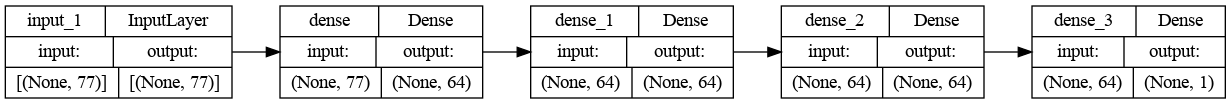

In [87]:
# Create the model architecture

#n_features = train_features.shape[1]
""" input = tf.keras.Input(shape=(n_features,))
model = tf.keras.Sequential()
model.add(input) """

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
""" model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu")) """

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

""" #x = tf.keras.layers.Dense(10)(x)
#output = tf.keras.layers.Dense(1)(x)
model.add(tf.keras.layers.Dense(1))

#model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR") """

In [194]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  #n_features = train_features.shape[1]
  input = tf.keras.Input(shape=(n_features,))
  model = tf.keras.Sequential()
  model.add(input)

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  #initializer = tf.keras.initializers.GlorotNormal()
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activation,kernel_initializer=initializer))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error')   

  return model

In [185]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=100,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_left_OneHotEnc')

INFO:tensorflow:Reloading Tuner from ./Hypertuning/hypertuning_left_OneHotEnc/tuner0.json


In [186]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
#tuner.search(train_features, train_labels, epochs=100, validation_split=0.1, batch_size=2, callbacks=[stop_early])
tuner.search(x_train, y_train, epochs=200, validation_split=0.1, batch_size=2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 1
n_units: 32
learning_rate: 0.01
activation_function: relu



In [195]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/100
90/90 - 0s - loss: 0.8091 - val_loss: 0.4896 - lr: 0.0100 - 308ms/epoch - 3ms/step
Epoch 2/100
90/90 - 0s - loss: 0.5405 - val_loss: 0.4252 - lr: 0.0100 - 55ms/epoch - 609us/step
Epoch 3/100
90/90 - 0s - loss: 0.4133 - val_loss: 0.4162 - lr: 0.0100 - 52ms/epoch - 580us/step
Epoch 4/100
90/90 - 0s - loss: 0.4126 - val_loss: 0.7159 - lr: 0.0100 - 53ms/epoch - 584us/step
Epoch 5/100
90/90 - 0s - loss: 0.4118 - val_loss: 0.3996 - lr: 0.0100 - 55ms/epoch - 611us/step
Epoch 6/100
90/90 - 0s - loss: 0.3505 - val_loss: 0.2493 - lr: 0.0100 - 56ms/epoch - 617us/step
Epoch 7/100
90/90 - 0s - loss: 0.3115 - val_loss: 0.2630 - lr: 0.0100 - 56ms/epoch - 617us/step
Epoch 8/100
90/90 - 0s - loss: 0.3414 - val_loss: 0.3572 - lr: 0.0100 - 54ms/epoch - 602us/step
Epoch 9/100
90/90 - 0s - loss: 0.2914 - val_loss: 0.4172 - lr: 0.0100 - 54ms/epoch - 601us/step
Epoch 10/100
90/90 - 0s - loss: 0.2968 - val_loss: 0.2880 - lr: 0.0100 - 53ms/epoch - 593us/step
Epoch 11/100
90/90 - 0s - loss: 0.2992 -

Best epoch: 12


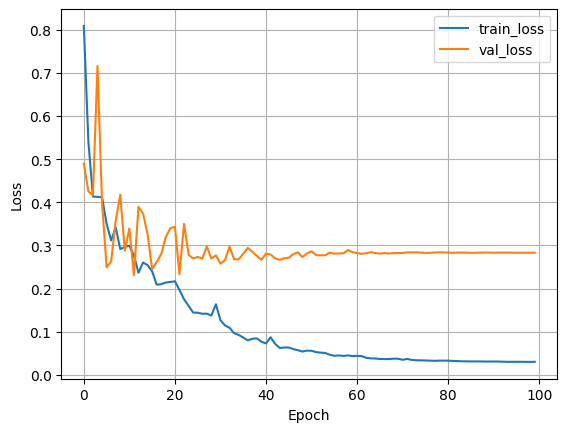

In [196]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [197]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

best_model = tuner.hypermodel.build(best_hps)

# Retrain the model
best_model.fit(x_train, y_train, epochs=best_epoch, batch_size=2, validation_split=0.1,callbacks=[reduce_lr], verbose=2)

Epoch 1/12
90/90 - 0s - loss: 0.7276 - val_loss: 0.6038 - lr: 0.0100 - 300ms/epoch - 3ms/step
Epoch 2/12
90/90 - 0s - loss: 0.5307 - val_loss: 0.5518 - lr: 0.0100 - 54ms/epoch - 599us/step
Epoch 3/12
90/90 - 0s - loss: 0.4603 - val_loss: 0.3596 - lr: 0.0100 - 54ms/epoch - 598us/step
Epoch 4/12
90/90 - 0s - loss: 0.3966 - val_loss: 0.3893 - lr: 0.0100 - 54ms/epoch - 605us/step
Epoch 5/12
90/90 - 0s - loss: 0.3493 - val_loss: 0.3696 - lr: 0.0100 - 53ms/epoch - 589us/step
Epoch 6/12
90/90 - 0s - loss: 0.4360 - val_loss: 0.2674 - lr: 0.0100 - 51ms/epoch - 571us/step
Epoch 7/12
90/90 - 0s - loss: 0.3527 - val_loss: 0.3626 - lr: 0.0100 - 53ms/epoch - 590us/step
Epoch 8/12
90/90 - 0s - loss: 0.3057 - val_loss: 0.3437 - lr: 0.0100 - 53ms/epoch - 586us/step
Epoch 9/12
90/90 - 0s - loss: 0.2927 - val_loss: 0.3444 - lr: 0.0100 - 53ms/epoch - 588us/step
Epoch 10/12
90/90 - 0s - loss: 0.2821 - val_loss: 0.3258 - lr: 0.0100 - 54ms/epoch - 595us/step
Epoch 11/12
90/90 - 0s - loss: 0.2799 - val_loss: 

In [198]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 1ms/step
(50, 1)
(50, 1)


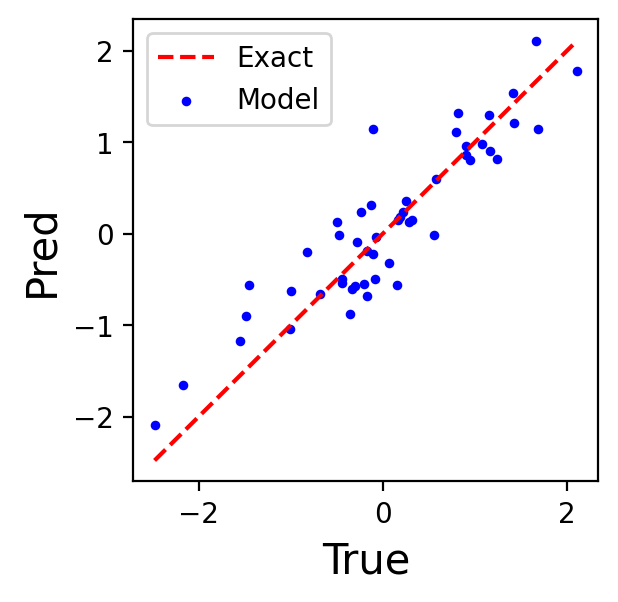

Test MAE: 0.3132191808001442


In [199]:
# Pred vs True values on test set 

#y_pred = model.predict(test_features)
y_pred = model.predict(x_test)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

7/7 [==============================] - 0s 758us/step
(199, 1)
(199, 1)


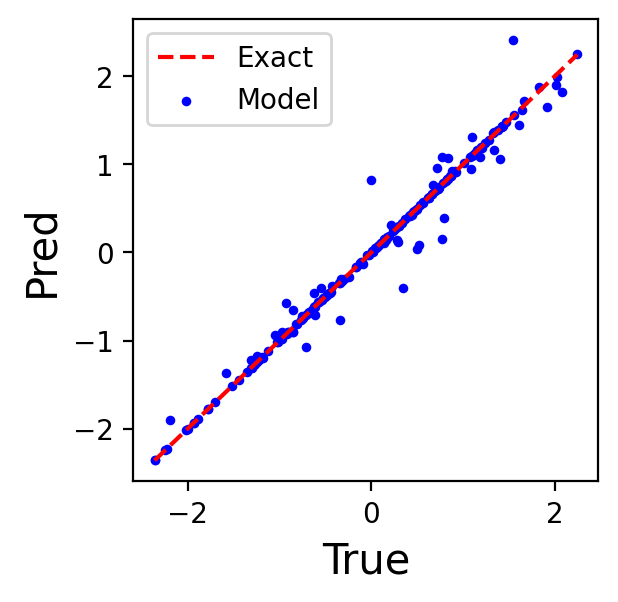

Train MAE: 0.055156342538778


In [200]:
# Pred vs True values on training set 

y_pred = model.predict(x_train)
y_pred.shape
y_true = np.zeros((len(y_train),1))
y_true[:,0] = y_train[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

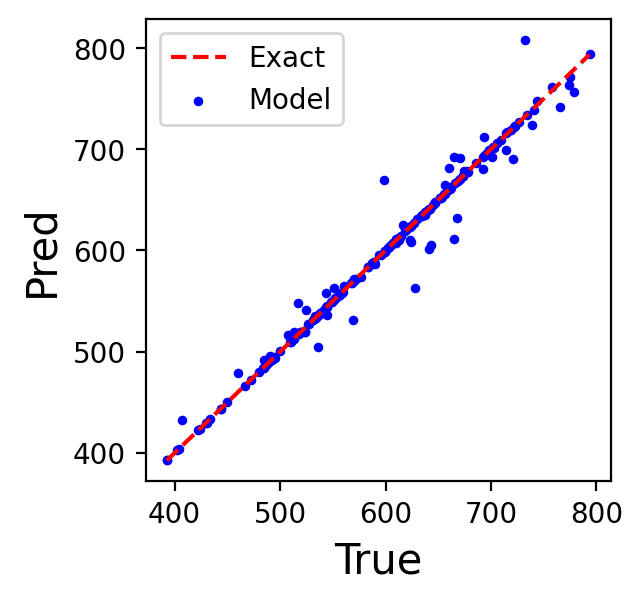

Train MAE (non-normalized): 4.798817414464906


In [201]:
# Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae))

In [139]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

7/7 [==============================] - 0s 614us/step


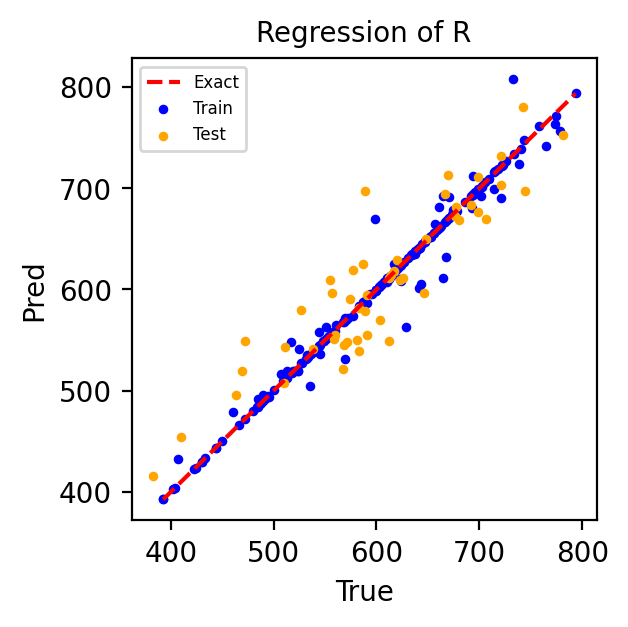

train MAE (non-normalized): 4.798817414464906
test MAE (non-normalized): 27.251258836914065


In [202]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(x_test)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

y_pred_train = model.predict(x_train)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

#y_pred_val = model.predict(val_ds)
#y_true_val = np.zeros((len(val['target']),1))
#y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

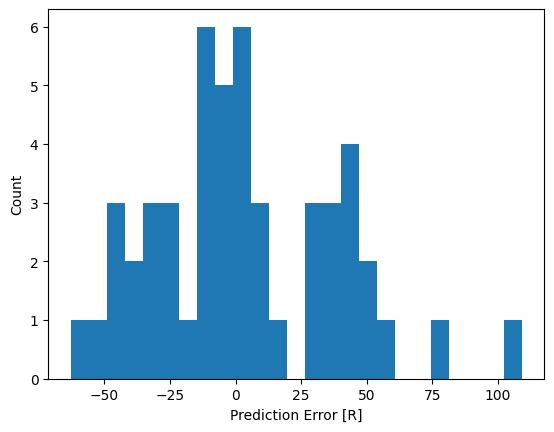

In [203]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
